In [1]:
# Install dependencies
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q ultralytics opencv-python matplotlib scikit-learn rembg onnxruntime patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
# Step 1: Mount Google Drive and Extract Dataset
from google.colab import drive
import patoolib
import os
import pandas as pd
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt
from rembg import remove
from PIL import Image
import random
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')

# Extract dataset
rar_path = '/content/drive/My Drive/new_OPA.rar'
patoolib.extract_archive(rar_path, outdir="/content/opa_dataset")


INFO patool: Extracting /content/drive/My Drive/new_OPA.rar ...
INFO:patool:Extracting /content/drive/My Drive/new_OPA.rar ...


Mounted at /content/drive


INFO patool: ... creating output directory `/content/opa_dataset'.
INFO:patool:... creating output directory `/content/opa_dataset'.
INFO patool: running /usr/bin/unrar x -kb -or -- "/content/drive/My Drive/new_OPA.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/drive/My Drive/new_OPA.rar"
INFO patool: ... /content/drive/My Drive/new_OPA.rar extracted to `/content/opa_dataset'.
INFO:patool:... /content/drive/My Drive/new_OPA.rar extracted to `/content/opa_dataset'.


'/content/opa_dataset'

In [19]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_EPOCHS = 10
DATA_SAMPLE = 500
OUTPUT_SIZE = (1024, 1024)

# Load backgrounds dynamically based on object type
def load_backgrounds(object_name):
    bg_dir = f"/content/opa_dataset/new_OPA/background/{object_name}"
    if os.path.exists(bg_dir):
        backgrounds = [os.path.join(bg_dir, f) for f in os.listdir(bg_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
        if backgrounds:
            print(f"Loaded {len(backgrounds)} background images for {object_name}")
            return backgrounds
    print(f"No backgrounds found for {object_name}, using default backgrounds.")
    return []


# Load and prepare dataset
def load_data(csv_path):
    df = pd.read_csv(csv_path).sample(DATA_SAMPLE, random_state=42)
    images, annotations = [], []
    for _, row in df.iterrows():
        img_path = os.path.join("/content/opa_dataset/new_OPA/composite", row['img_name'].split('/', 2)[-1])
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE)
        position = eval(row['position'])
        h, w = image.shape[:2]
        annotations.append([position[0] / w, position[1] / h, position[2] / w, position[3] / h])
        images.append(image)
    return np.array(images), np.array(annotations)

train_images, train_ann = load_data('/content/opa_dataset/new_OPA/train_set.csv')
test_images, test_ann = load_data('/content/opa_dataset/new_OPA/test_set.csv')

# Dataset and DataLoader
class PlacementDataset(Dataset):
    def __init__(self, images, annotations, transform=None):
        self.images = images
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image.transpose(2, 0, 1) / 255.0, dtype=torch.float32)
        return image, torch.tensor(self.annotations[idx], dtype=torch.float32)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

train_dataset = PlacementDataset(train_images, train_ann, transform=train_transform)
test_dataset = PlacementDataset(test_images, test_ann)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [20]:
# Define CNN model
class PlacementNet(nn.Module):
    def __init__(self):
        super(PlacementNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.reshape(-1, 64 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PlacementNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {running_loss / len(train_loader):.4f}")

torch.save(model.state_dict(), 'placement_model.pth')
print("Training completed and model saved.")


Epoch 1/10, Loss: 0.3786
Epoch 2/10, Loss: 0.3751
Epoch 3/10, Loss: 0.3746
Epoch 4/10, Loss: 0.3747
Epoch 5/10, Loss: 0.3738
Epoch 6/10, Loss: 0.3758
Epoch 7/10, Loss: 0.3729
Epoch 8/10, Loss: 0.3749
Epoch 9/10, Loss: 0.3758
Epoch 10/10, Loss: 0.3744
Training completed and model saved.


In [27]:
# Object placement processing
class ObjectPlacer:
    def __init__(self, model):
        self.model = model
        self.device = device

    def remove_background(self, img):
        return np.array(remove(Image.fromarray(img)))

    def blend_with_background(self, bg, fg, position):
        x, y = position
        h, w = fg.shape[:2]
        mask = fg[:, :, 3] if fg.shape[2] == 4 else np.ones((h, w), dtype=np.uint8) * 255
        mask = cv2.GaussianBlur(mask, (15, 15), 5)
        fg_rgb = fg[:, :, :3] if fg.shape[2] == 4 else fg
        alpha = mask / 255.0
        for c in range(3):
            bg[y:y+h, x:x+w, c] = alpha * fg_rgb[:, :, c] + (1 - alpha) * bg[y:y+h, x:x+w, c]
        return bg

    def find_best_position(self, bg, obj_h, obj_w):
        h, w, _ = bg.shape
        for _ in range(10):  # Try 10 random placements
            x, y = random.randint(50, w - obj_w - 50), random.randint(50, h - obj_h - 50)
            if np.mean(bg[y:y+obj_h, x:x+obj_w]) > 50:  # Ensure it's not too dark (e.g., shadows)
                return x, y
        print("No perfect space encountered, placing object in a logical position.")
        return w // 2 - obj_w // 2, h - obj_h - 100  # Place near bottom center

    def place_object(self, object_img, object_name):
        object_img = self.remove_background(object_img)
        backgrounds = load_backgrounds(object_name)
        if not backgrounds:
            print("No relevant background found, stopping process.")
            return None

        random.shuffle(backgrounds)  # Try different backgrounds if needed
        for bg_path in backgrounds:
            bg = cv2.imread(bg_path)
            bg = cv2.resize(bg, OUTPUT_SIZE)
            obj_h, obj_w = object_img.shape[:2]
            x, y = self.find_best_position(bg, obj_h, obj_w)

            # Blend with the selected background
            return self.blend_with_background(bg, object_img, (x, y))

        print("Failed to place object on all backgrounds.")
        return None

Enter the object name (book, bottle, etc.): bottle
Please upload the object image...


Saving 78943.jpg to 78943.jpg
Loaded 41 background images for bottle


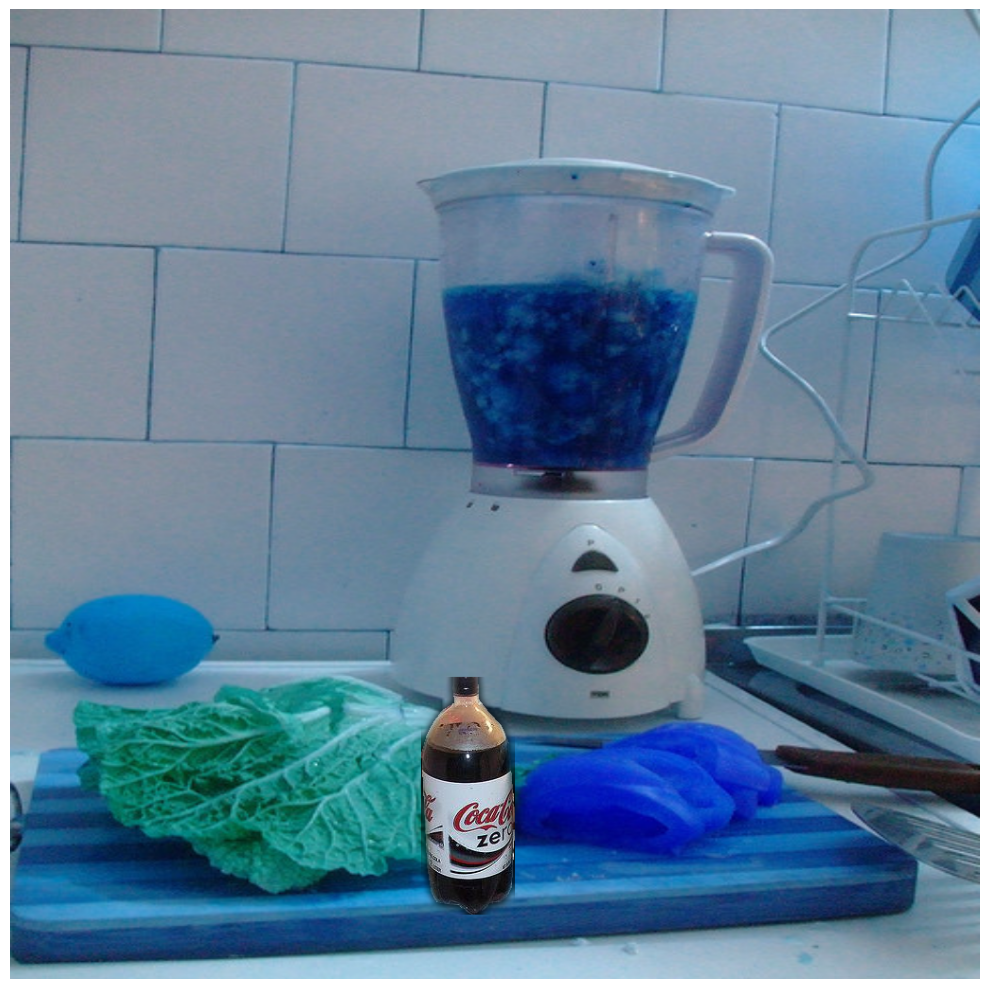

In [30]:
# Upload and process image
placer = ObjectPlacer(model)

# Step 1: Ask the user for the object name
object_name = input("Enter the object name (book, bottle, etc.): ").strip().lower()

# Step 2: Upload the image
print("Please upload the object image...")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
user_image = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), cv2.IMREAD_UNCHANGED)


# Ensure correct color format
if user_image.shape[2] == 3:
    user_image = cv2.cvtColor(user_image, cv2.COLOR_BGR2RGB)
else:
    user_image = cv2.cvtColor(user_image, cv2.COLOR_BGRA2RGBA)

# Step 3: Process and place object in the background
result = placer.place_object(user_image, object_name)
if result is not None:
    plt.figure(figsize=(12, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.tight_layout()
    plt.show()